In [56]:
from os import path
from matplotlib_venn import venn2, venn3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Author:
Simon Hackl, 28.02.2021

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S10_SNVdiscovery.sh` script and the manual SNV discovery runs of `DNAdiff` and `mauve` on the CFT073 unicycler (hybrid) and trycycler (+ medaka) assemblies. In order to use this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

####  Extracting SNV position information from the respective reports.

The following three methods are used to extract information about the SNV positions from the respective reports. As a result a dictionary will be created that stores the reference and called alternative base accessible via the position of the call. Additional information on the input formats for these methods can be found below:
- VCF file format: https://samtools.github.io/hts-specs/VCFv4.2.pdf
- DNAdiff SNP report: http://mummer.sourceforge.net/manual/ (`show-snps` section)
- Mauve SNP report: http://gensoft.pasteur.fr/docs/Mauve/2.3.1/mauve_user_guide.pdf (page 23 and 24)

In [405]:
def extractVCF( filepath, DP, QUAL ) :
    ''' Extracts positions and base calls from a VCF file.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of .vcf file.
        
    DP : int
        Only reports positions with a read coverage higher or equal to the passed value.
    
    QUAL : int
        Only reports positions with a reported quality higher or equal to the passed value.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        SNPs = { }
        sampleNames = dict( 
            enumerate( 
                path.basename( filepath ).split( "-" )[ 0 ].split( "~" ), 
                start = 0
            )
        )
        while line :
            if line.startswith("#") : # Skip comment lines
                line = file.readline( )
                continue
            else :
                data = line.split("\t") # Else each column is accessed by splitting the line at tabulator symbols.
                genotypeData = data[9:]
                genotypeData[-1] = genotypeData[-1].strip( )
                quality = float( data[ 5 ] )
                depth = int( data[ 7 ].split( ";" )[ 0 ].split( "=" )[ 1 ] )
                # If the specified quality and coverage depth thresholds are fullfilled, the positions are stored.
                if quality >= QUAL and depth >= DP :
                    SNPs[ int( data[ 1 ] ) ] = {
                        "REF" : data[ 3 ],
                        "ALT" : data[ 4 ],
                        "GT" : { }
                    }
                    if len( genotypeData ) > 1 and genotypeData[ 0 ] == genotypeData[ 1 ] :
                        SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ 0 ] ] = genotypeData[ 0 ]
                        SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ 1 ] ] = genotypeData[ 1 ]
                    else :   
                        for entry in genotypeData :
                            sampleNr = genotypeData.index( entry )
                            SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ sampleNr ] ] = entry
                            
            line = file.readline( )
    return SNPs

In [406]:
def extractDNAdiff( filepath ) :
    ''' Extracts positions and base calls from a DNAdiff .snps file.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of DNAdiff .snps file.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        SNPs = { }
        while line :
            data = line.split( "\t" )
            pos = int( data[ 0 ] )
            ref = data[ 1 ]
            alt = data[ 2 ]
            if ref == "." or alt == "." : # If the position represents an indel, it is skipped.
                pass
            else :
                SNPs[ pos ] = { 'REF': ref, 'ALT': alt }
            line = file.readline( )
    return SNPs

In [407]:
def extractMauve( filepath ) :
    ''' Extracts positions and base calls from a Mauve SNPs report.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of Mauve .txt file generated with the Export SNPs option.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        skipHeader = True
        SNPs = { }
        while line :
            if skipHeader :
                skipHeader = False
            else :
                data = line.split( "\t" )
                pos = int( data[ 3 ] )
                ref = data[ 0 ][ 0 ]
                alt = data[ 0 ][ 1 ]
                if ref == "." or alt == "." or ref == "-" or alt == "-" : # If the position represents an indel, it is skipped.
                    pass
                else :
                    SNPs[ pos ] = { 'REF': ref, 'ALT': alt }
            line = file.readline( )
    return SNPs

---

#### Parsing the output files into dictionaries
With the methods above the respective report files can be parsed into dictionaries. For the `.vcf` files a depth of coverage of at least 40 and a quality of at least 50 are used as cutoff values to store a position.

In [408]:
info_bcftools_s = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8482585-bcftools.vcf", 40, 50 )
info_bcftools_l = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8494940-bcftools.vcf", 40, 50 )
info_bcftools_ls = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8494940~SRR8482585-bcftools.vcf", 40, 50 )
info_dnadiff_uh = extractDNAdiff( "./results/SNVDiscovery/CFT073/dnadiff/unicycler~hybrid-dnadiff.snps" )
info_dnadiff_tm = extractDNAdiff( "./results/SNVDiscovery/CFT073/dnadiff/trycycler_medaka-dnadiff.snps" )
info_mauve_uh = extractMauve( "./results/SNVDiscovery/CFT073/mauve/unicycler~hybrid-mauve.snps" )
info_mauve_tm = extractMauve( "./results/SNVDiscovery/CFT073/mauve/trycycler_medaka-mauve.snps" )

---
#### Definition of a reference SNV set
As no reliable set of reference SNVs is present for evaluating the SNVs detected with the above mentioned approches, a consensus calling of the SNVs discovered with DNAdiff and mauve using the unicycler hybrid assembly and the SNVs called with the short reads using bcftools is conducted.
This approach, however, implies that the short reads and hybrid assemblies yield more likely SNVs than the other approaches. 

To do this all SNVs sharing the position and alternative base call by any two of the three sets is considered as a reference SNV. The therewith obtained SNVs are stored in a dictionary like the info_... variables before.

In [409]:
# Define a method to convert the `info_...` dictionaries into a set of tuples, each with a position and alternative base entry.
toPosAlt = lambda dictionary : set( [ ( key, value[ 'ALT' ] ) for key, value in dictionary.items( ) ] )
# The reference SNVs can be computed as the union of all pairwise set intersections:

referenceSNVs = dict( )
for pos, alt in sorted( list( 
    ( toPosAlt( info_bcftools_s ) & toPosAlt( info_dnadiff_uh ) ) | \
    ( toPosAlt( info_bcftools_s ) & toPosAlt( info_mauve_uh ) ) | \
    ( toPosAlt( info_mauve_uh ) & toPosAlt( info_dnadiff_uh ) )
) ) :
    referenceSNVs[ pos ] = { 'ALT' : alt }

In addition the set of reference SNVs is visualized as a Venn diagramm relative to the three sets from which it was built in the following.

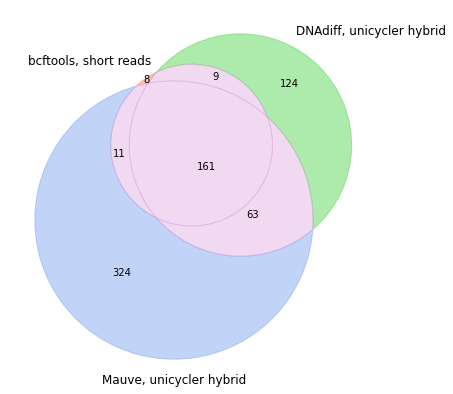

In [410]:
plt.figure( figsize = ( 7, 7 ) )
v = venn3( [ toPosAlt( info_bcftools_s ), toPosAlt( info_dnadiff_uh ), toPosAlt( info_mauve_uh ) ],
           ( "bcftools, short reads", "DNAdiff, unicycler hybrid", "Mauve, unicycler hybrid" )
         )
v.get_patch_by_id('100').set_color('tomato')
v.get_patch_by_id('010').set_color('limegreen')
v.get_patch_by_id('001').set_color('cornflowerblue')
v.get_patch_by_id('110').set_color('plum')
v.get_patch_by_id('101').set_color('plum')
v.get_patch_by_id('011').set_color('plum')
v.get_patch_by_id('111').set_color('plum')

---

#### Computing pairwise intersections of all SNV sets
In the following an overview of the pairwise intersection of each SNV set will be depicted.

In [411]:
def getIntersection2D( sets ) :
    ''' Computes an 2D list in which each cell i,j contains the size of the intersection between set
    i and set j. If j > i the dummy value `np.nan` will be stored to avoid duplicates.
    
    Parameters
    ----------
    sets : list
        A list containing sets.
    '''
    info2D = [ ]
    setsIndexList = range( len( sets ) )
    for i in setsIndexList :
        info2D.append( [ ] )
        for j in setsIndexList :
            if j <= i :
                info2D[ i ].append( len( sets[ i ].intersection( sets[ j ] ) ) )
            else :
                info2D[ i ].append( np.nan )
    return info2D

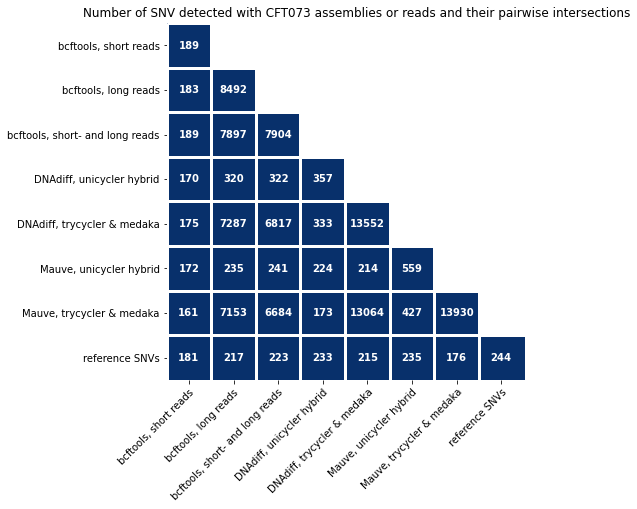

In [412]:
# To simplify the computation the following lists store each SNV info set and an corresponding label,
# as well as the reference SNV set computed before.
infos = [ info_bcftools_s, info_bcftools_l, info_bcftools_ls, info_dnadiff_uh, info_dnadiff_tm, info_mauve_uh, info_mauve_tm, referenceSNVs ]
info_labels = [ "bcftools, short reads", "bcftools, long reads", "bcftools, short- and long reads", "DNAdiff, unicycler hybrid", "DNAdiff, trycycler & medaka", "Mauve, unicycler hybrid", "Mauve, trycycler & medaka", "reference SNVs" ]

# Each SNV info set is converted into a set of tuples, each storing the reference position and alternative base.
# These sets are used as input for the `getIntersection2D` method.
info2D = getIntersection2D( [ set( [ ( key, value[ 'ALT' ] ) for key, value in i.items( ) ] ) for i in infos ] )

fig, ax = plt.subplots( figsize = ( 6, 6 ) )
fig.tight_layout()
im = ax.imshow( info2D , cmap="Blues", vmin=1, vmax=10**2 ) # Change the vmin and vmax values for coloring to achieve a constant color.
plt.setp( ax.xaxis.get_majorticklabels( ), rotation=45, ha="right", rotation_mode="anchor" )
plt.setp( ax.yaxis.get_majorticklabels( ), rotation=0, ha="right", rotation_mode="anchor" )
plt.title( "Number of SNV detected with CFT073 assemblies or reads and their pairwise intersections" )

info2Dsize = len( info2D )
for i in range( info2Dsize ) :
    for j in range( info2Dsize ) :
        #if j == i + 1 :
        #    TP = info2D[ info2Dsize - 1 ][ i ]
        #    FP = info2D[ i ][ j - 1 ] - info2D[ info2Dsize - 1 ][ i ]
        #    text = ax.text(j, i, round( ( TP / ( TP + FP ) ), 2 ), ha="center", va="center", color="black", fontweight="bold")
        if not np.isnan( info2D[ i ][ j ] ) :
            # Each cell of the heatmap is labeled with the size of the intersection.
            text = ax.text(j, i, info2D[ i ][ j ], ha="center", va="center", color="w", fontweight="bold")

# Set predefined labels.
ax.set_xticks( np.arange( len( info_labels ) ) )
ax.set_yticks( np.arange( len( info_labels ) ) )        
ax.set_xticklabels( info_labels )
ax.set_yticklabels( info_labels )

# Draw a white grid for better separation of the single fields:
ax.grid( True, which="minor", color="w", linestyle='-', linewidth=1 )
ax.tick_params( which="minor", bottom=False, left=False )
for i in range( len( info_labels ) ) :
    plt.vlines( i - 0.5, -0.5, len( info_labels ) - 0.5, color="w", linewidth=3 )
    plt.hlines( i - 0.5, -0.5, len( info_labels ) - 0.4, color="w", linewidth=3 )

# Remove axis bars.
for edge, spine in ax.spines.items():
    spine.set_visible(False)

---

#### Detailed evaluation of the bcftools sets
To evaluate more in detail how the use of long reads may influence SNV discovery (relative to the use of short reads alone), the sets computed with `bcftools` are analyzed further in the following:
- It is checked if the called alternative base differs between the `bcftools` sets with combined or single read sets.
- It is checked how many reference SNVs were discovered with the long read set that were not called with the short read set. 

In [413]:
data = { 'position' : [ 'bcftools_ls.GT_s', 'bcftools_ls.GT_l', 'bcftools_ls.ALT', 'bcftools_s.GT', 'bcftools_s.ALT', 'bcftools_l.GT', 'bcftools_l.ALT' ] }
getGenotype = lambda info, sampleID : info[ key ][ 'GT' ][ sampleID ].split( ":" )[ 0 ]

for key, value in referenceSNVs.items( ) :
    newRow = [ ]
    
    if key in info_bcftools_ls :
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8482585' ) )
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8494940' ) )
        newRow.append( info_bcftools_ls[ key ][ 'ALT' ] )
    else :
        newRow.append( '0' )
        newRow.append( '0' )
        newRow.append( '-' )
        
    if key in info_bcftools_s :
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8482585' ) )
        newRow.append( info_bcftools_s[ key ][ 'ALT' ] )
    else :
        newRow.append( '0' )
        newRow.append( '-' )
        
    if key in info_bcftools_l :
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8494940' ) )
        newRow.append( info_bcftools_l[ key ][ 'ALT' ] )
    else :
        newRow.append( '0' )
        newRow.append( '-' )
        
    data[ key ] = newRow
    
bcftoolsData = pd.DataFrame( data )
bcftoolsData.set_index( "position", inplace = True )
index = pd.MultiIndex.from_tuples( [ c.split( "." ) for c in bcftoolsData.index ] )
bcftoolsData.set_index( index, inplace = True )
bcftoolsData.sort_index( level = 1, inplace = True )
bcftoolsData.sort_values( 
    [ ( 'bcftools_s', 'GT'), ( 'bcftools_l', 'GT'), ( 'bcftools_ls', 'GT_s'), ( 'bcftools_ls', 'GT_l') ],
    axis = 1, inplace = True
)

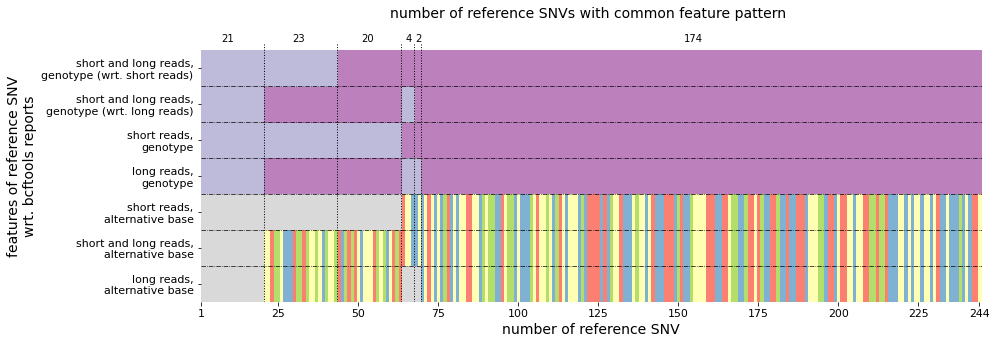

In [414]:
plotData = bcftoolsData \
    .replace( '1', 10 ) \
    .replace( '0', 3 ) \
    .replace( '.', 3 ) \
    .replace( 'A', 4 ) \
    .replace( 'C', 5 ) \
    .replace( 'G', 2 ) \
    .replace( 'T', 7 ) \
    .replace( '-', 9 )

fig, ax = plt.subplots( figsize = ( 14, 5  ) )
ax.pcolor( plotData, cmap = "Set3", vmin = 1, vmax = 12 )

ax.set_xlim( 0, bcftoolsData.shape[ 1 ] )
xticks = [ 1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 244 ]
ax.set_xticks( [ i - 0.75 for i in xticks ] )
ax.set_xticklabels( xticks, fontsize = 11 )
ax.set_xlabel( "number of reference SNV", fontsize = 14 )

ax.set_yticks( np.arange( 0.5, bcftoolsData.shape[ 0 ], 1 ) );
ax.set_yticklabels( 
    [ "long reads,\nalternative base",
      "short and long reads,\nalternative base",
      "short reads,\nalternative base",
      "long reads,\ngenotype",
      "short reads,\ngenotype",
      "short and long reads,\ngenotype (wrt. long reads)",
      "short and long reads,\ngenotype (wrt. short reads)" ],
    fontsize = 11
)
ax.set_ylabel( "features of reference SNV\nwrt. bcftools reports", fontsize = 14 )

ax.hlines( np.arange( 1, len( bcftoolsData.index ) ), 0, bcftoolsData.shape[ 1 ], color = "black", linestyle="-.", linewidth = 0.7 )

groupBorders = [ 20, 43, 63, 67, 69 ] 
ax.vlines( [ b - 0.25 for b in groupBorders ], 0, 7.2, color = "black", linestyle = ":", linewidth = 1 )

# Remove axis bars.
for edge, spine in ax.spines.items():
    spine.set_visible(False)
    
lastSize = 0
groupBorders.append( 243 )
for gb in groupBorders :
    gb = gb + 1
    size = gb - lastSize
    text = ax.text( lastSize + ( size / 2 ), 7.3, size, ha="right", va="center", color="black" )
    lastSize = gb
    
text = ax.text( 121, 8, "number of reference SNVs with common feature pattern", ha="center", va="center", color="black", fontsize = 14 )

In [418]:
genotypeLikelihoodShortreadsRef = [ ]
genotypeLikelihoodShortreadsAlt = [ ]
genotypeLikelihoodLongreadsRef = [ ]
genotypeLikelihoodLongreadsAlt = [ ]
for key, value in info_bcftools_ls.items( ) :
    if key not in referenceSNVs :
        genotypeLikelihoodShortread = info_bcftools_ls[ key ][ "GT" ][ "SRR8482585" ].split( ":" )[ 1 ].split( "," )
        genotypeLikelihoodLongread = info_bcftools_ls[ key ][ "GT" ][ "SRR8494940" ].split( ":" )[ 1 ].split( "," )
        
        genotypeLikelihoodShortreadsRef.append( int( genotypeLikelihoodShortread[ 0 ] ) )
        genotypeLikelihoodShortreadsAlt.append( int( genotypeLikelihoodShortread[ 1 ] ) )
        genotypeLikelihoodLongreadsRef.append( int( genotypeLikelihoodLongread[ 0 ] ) )
        genotypeLikelihoodLongreadsAlt.append( int( genotypeLikelihoodLongread[ 1 ] ) )

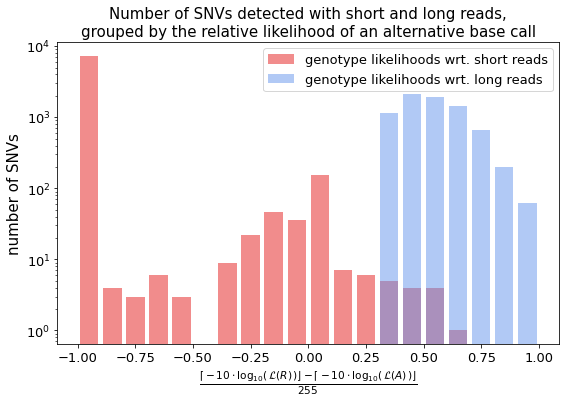

In [465]:
relativeLikelihoods = lambda likelihoodsRef, likelihoodsAlt : [ ( r - a ) / 255 for r, a in zip( likelihoodsRef, likelihoodsAlt ) ]

plt.figure( figsize=( 9, 9 / 1.618 ) )

plt.xlabel( r'$\frac{ \lceil-10\cdot \log_{10}(\,{\cal L}(R)\,)\rfloor - \lceil-10\cdot \log_{10}(\,{\cal L}(A)\,)\rfloor}{255} $', fontsize = 15 )
plt.xticks( fontsize = 13 )

plt.ylabel( "number of SNVs", fontsize = 15 )
plt.yticks( fontsize = 13 )

plt.hist( relativeLikelihoods( genotypeLikelihoodShortreadsRef, genotypeLikelihoodShortreadsAlt ), bins = np.arange( -1, 1.1, 0.1 ), rwidth=0.8, label = "genotype likelihoods wrt. short reads", color = "lightcoral", alpha = 0.9 );
plt.hist( relativeLikelihoods( genotypeLikelihoodLongreadsRef, genotypeLikelihoodLongreadsAlt ), bins = np.arange( -1, 1.1, 0.1 ), rwidth=0.8, label = "genotype likelihoods wrt. long reads", color = "cornflowerblue", alpha = 0.5 );
plt.yscale( "log" )

plt.title( "Number of SNVs detected with short and long reads,\ngrouped by the relative likelihood of an alternative base call", fontsize = 15 )

plt.legend( fontsize = 13 );